In [4]:
%load_ext rpy2.ipython
# Turning on in-IPy R capabilities

In [2]:
%%R
library(phyloseq)
library(doParallel)
library(ggplot2)
library(vegan)
library(RColorBrewer)
library(plyr)

Loading required package: foreach
foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com
Loading required package: iterators
Loading required package: parallel
Loading required package: permute
Loading required package: lattice
This is vegan 2.2-1


In [3]:
%%R
#Creating the physeq object from our tree and biom table with taxonimic and metadata already included, telling it \
# that the taxonomy is from greengenes database, so it will recognize the samples
physeq = import_biom("otu_table_tax_no211_meta.biom", treefilename = "ssu-aln.bacteria.mask.tre",
                    parseFunction = parse_taxonomy_greengenes)

In [9]:
%%R
# Normalizes the sample counts by the total - i.e., reporting what fraction of each sample each OTU makes up.
physeq_snorm = transform_sample_counts(physeq, function(x) x / sum(x))

In [10]:
%%R
# Computing the weighted unifrac distance matrix using the new "fast" algorithm, then performing a PCoA, in parallel
registerDoParallel(cores=10)
ord = ordinate(physeq_snorm, method = "PCoA", distance = "unifrac", weighted = TRUE, fast = TRUE, parallel = TRUE)

In [11]:
%%R
# Takes the plot_ordination command, but doesn't actually plot it - just reports the dataframe.
# It uses the metadata from the normalize physeq file, and looks only at the first few axes.
df.sites = plot_ordination(physeq_snorm, ord, axes = c(1,2,3), justDF = TRUE)
head(df.sites)

           Axis.1        Axis.2       Axis.3 Plants DayAmdmt Amdmt ID Day
S009  0.030971709  0.0353643596 -0.019981227      1       01     1  D   0
S204  0.005130770 -0.0213532203 -0.002824307      1       21     1  D   2
S112  0.006147569 -0.0003299146  0.032671437      0       11     1  B   1
S247 -0.026228092 -0.0181962034 -0.028786487      0       22     2  F   2
S026  0.022805058  0.0151645325 -0.036224373      0       00     0  A   0
S023  0.034691120  0.0447972216 -0.025031304      1       00     0  C   0


In [5]:
%%R -h 500 -w 1400
# Sets the window size above - has to happen on the first row.

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
# It is colored by Amendment (Amdmt)
p = ggplot(df.sites, aes(x = Axis.1, y = Axis.2, color = Amdmt, shape = Amdmt))

# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days
# The axis scales are all optimized individually
# There is also a facet_grid function where you could do two variables A~B
p = p + facet_wrap(~Day, scales = "free")

# Determines the size of the symbols
p = p + geom_point(size = 3.5)

# Determines the color theme of the plot overall
p = p + theme_bw()

# Displays the plot object
p

Error in withVisible({ : could not find function "ggplot"


In [ ]:
%%R -h 500 -w 1400
# Sets the window size above - has to happen on the first row.

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
# It is colored by Amendment (Amdmt)
p = ggplot(df.sites, aes(x = Axis.1, y = Axis.2, color = Amdmt, shape = Amdmt))

# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days
# The axis scales are all optimized individually
# There is also a facet_grid function where you could do two variables A~B
p = p + facet_wrap(~Day, scales = "free")

# Determines the size of the symbols
p = p + geom_point(size = 3.5)

# Determines the color theme of the plot overall
p = p + theme_bw()

# Displays the plot object
p

In [44]:
%%R
# This function is taking each OTU, and using the wascores function to see where it would be "pulled to" in the
# ordination plot.

# We create an object using the first two axes from our ordination (but could choose other axes)
site.scores = df.sites[,c(1,2)]

# Make sure that the row names match up with the otu table row names before proceeding.
# Note the physeq otu table had to be transformed using the t() function, to flip rows and columns around.
# Expanding it means that it gets scaled back up to the error scale of the original plots - so they correspond correctly
# Spits out error messages if they tables are mismatched.
if( setequal(row.names(site.scores), row.names(t(otu_table(physeq_snorm)))) ){
    w = wascores(site.scores, t(otu_table(physeq_snorm)), expand = TRUE)
} else {
    print("Indices don't match")
    print(setdiff(row.names(site.scores), row.names(t(otu_table(physeq_snrom)))))
}    

head(w)

             Axis.1      Axis.2
OTU.3919 0.01838310 0.016524175
OTU.3038 0.02377268 0.024740698
OTU.2120 0.01948552 0.016771971
OTU.679  0.02073326 0.022967333
OTU.6355 0.01834763 0.031881580
OTU.299  0.01573563 0.009077457


In [45]:
%%R
# Similar approach to above - we take the object we created where we plotted the OTUs on the ordination
otu.scores = data.frame(w)

# We also pull out the taxonomy from the physeq object
supp = tax_table(physeq_snorm)

# Again, making sure they match up, now we join the two together so we have the OTU ordinations with the taxonomic info
if( setequal(row.names(otu.scores), row.names(supp)) ){
    otu.scores.wtax = data.frame(otu.scores, supp)
} else {
    print("Indices not the same.")
    print(setdiff(row.names(w.df), row.names(supp)))
}

head(otu.scores.wtax)

             Axis.1      Axis.2  Kingdom         Phylum               Class
OTU.3919 0.01838310 0.016524175 Bacteria Actinobacteria       Rubrobacteria
OTU.3038 0.02377268 0.024740698 Bacteria Proteobacteria Deltaproteobacteria
OTU.2120 0.01948552 0.016771971 Bacteria Proteobacteria Deltaproteobacteria
OTU.679  0.02073326 0.022967333 Bacteria Proteobacteria Deltaproteobacteria
OTU.6355 0.01834763 0.031881580 Bacteria  Acidobacteria              iii1-8
OTU.299  0.01573563 0.009077457 Bacteria  Acidobacteria              iii1-8
                      Order              Family Genus Species Rank1
OTU.3919    Rubrobacterales    Rubrobacteraceae  <NA>    <NA>  <NA>
OTU.3038 [Entotheonellales] [Entotheonellaceae]  <NA>    <NA>  <NA>
OTU.2120 [Entotheonellales] [Entotheonellaceae]  <NA>    <NA>  <NA>
OTU.679  [Entotheonellales] [Entotheonellaceae]  <NA>    <NA>  <NA>
OTU.6355              32-20                <NA>  <NA>    <NA>  <NA>
OTU.299               32-20                <NA>  <NA>    <NA

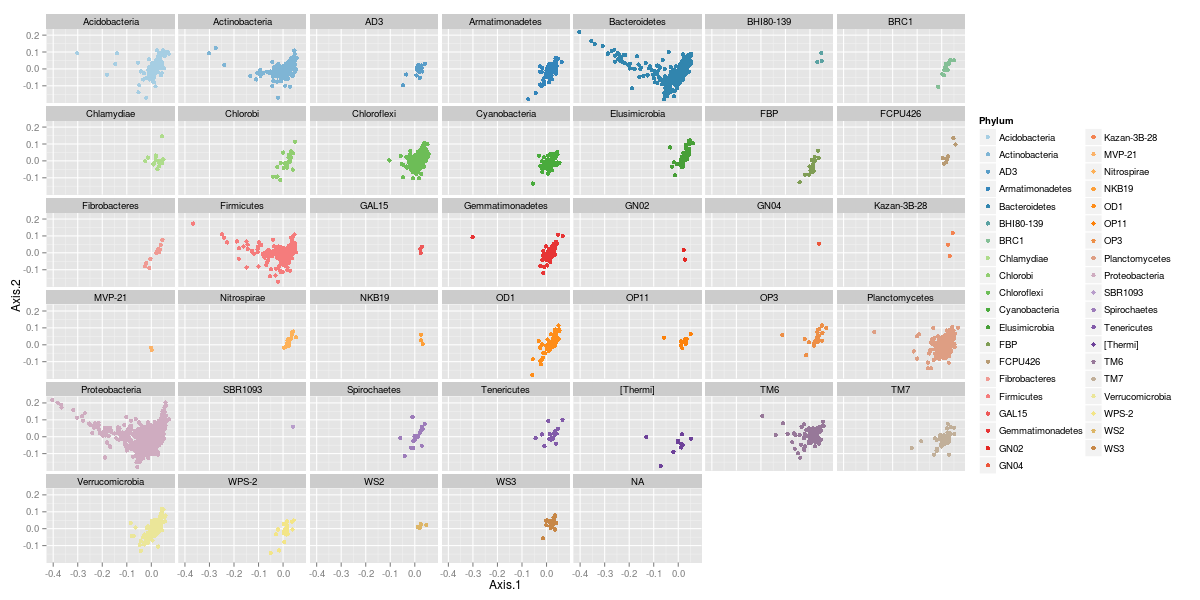

In [46]:
%%R -w 1200 -h 600
# Setting plot dimensions above - note this has to happen on the first line.
# Figuring out how many different colours we're going to need for all our unique categories we're going to plot
colourCount = length(unique(otu.scores.wtax$Phylum))
# Pulls out a specific colour palette from the R colour brewer, tells it to expand it by a certain number, and then 
# fills in the spaces with extra colours... not actually doing anything right now.
getPalette = colorRampPalette(brewer.pal(12, "Paired"))

# Creates plot object from the OTU ordination with taxa, plotting the two axes, but colouring by Phylum
p = ggplot(otu.scores.wtax, aes(x = Axis.1, y = Axis.2, color = Phylum))

# Used to create scatterplots - can specify many more things here
p = p + geom_point()

# Tells it to display the legend with two columns, so it doesn't run off the chart
p = p + guides(color = guide_legend(ncol = 2))

# Displays a graph for each different phylum
p = p + facet_wrap(~Phylum)

# Sets the colours using the colourCount defined above.
p = p + scale_color_manual(values = getPalette(colourCount))

p

In [57]:
%%R
# Sets up a modified dataframe by "melting" the physeq object into readable information.
mdf = psmelt(physeq_snorm)
head(mdf)

            OTU Sample  Abundance Plants DayAmdmt Amdmt ID Day  Kingdom
102237   OTU.18   S147 0.12353756      0       12     2  F   1 Bacteria
102301   OTU.18   S141 0.11247601      0       12     2  F   1 Bacteria
102224   OTU.18   S148 0.10962822      0       12     2  F   1 Bacteria
376742    OTU.4   S143 0.08268212      0       12     2  F   1 Bacteria
665320 OTU.6446   S145 0.07816556      0       12     2  F   1 Bacteria
911632    OTU.9   S147 0.07316590      0       12     2  F   1 Bacteria
               Phylum               Class              Order
102237 Proteobacteria Gammaproteobacteria  Enterobacteriales
102301 Proteobacteria Gammaproteobacteria  Enterobacteriales
102224 Proteobacteria Gammaproteobacteria  Enterobacteriales
376742 Proteobacteria  Betaproteobacteria    Burkholderiales
665320 Proteobacteria  Betaproteobacteria    Burkholderiales
911632  Bacteroidetes    Sphingobacteriia Sphingobacteriales
                    Family            Genus    Species Rank1
102237  

In [58]:
%%R
# Uses the plyr library to summarize the melted physeq object created above, by Sample and Phylum,
# and creating a new column, called S, which is the sum of the abundance column.
# Thus, this sum is telling us, for each sample, for each phylum, what fraction of the total each phylum makes up.
# There is a lot more that could be done here, but this has the makings of a stacked bar chart, etc.
d = ddply(mdf, .(Sample, Phylum), summarize, S = sum(Abundance))
head(d)

  Sample          Phylum            S
1   S001   Acidobacteria 2.063437e-01
2   S001  Actinobacteria 1.139791e-01
3   S001             AD3 1.337100e-03
4   S001 Armatimonadetes 7.069192e-03
5   S001   Bacteroidetes 6.439011e-02
6   S001       BHI80-139 2.325392e-05


In [ ]:
%%R
# Uses the new dplyr library to summarize the melted physeq object created above, by Sample and Phylum,
# and creating a new column, called S, which is the sum of the abundance column.
# Thus, this sum is telling us, for each sample, for each phylum, what fraction of the total each phylum makes up.
# There is a lot more that could be done here, but this has the makings of a stacked bar chart, etc.
# dplyr isn't installed yet so this doesn't work

#SamplesByPhylum <- group_by(mdf,Sample,Phylum)
#SamplesByPhylum.summ <- (mdf,SamplesByPhylum,S=sum(Abundance))
#head(SamplesByPhylum.summ)

In [ ]:
%%R
# This is Chantal's example of running an ordination for a bunch of different sets (here, days, like me), all at once
# She creates a list of the variables she wants to run the ordination by
days = list(day3=3, day7=7, day14=14, day30=30)

# She pulls out the sample data from her physeq object
md = sample_data(physeq.fungi.thresh)

# She creates a function that prunes samples where the Day is equal to the value from her list created above,
# and the sample ID is not D312.6 (I guess she was omitting that sample), for her physeq object.
ord = function(x) {
    ps = prune_samples((md$Day == x)&(md$SampleID != "D312.6"), physeq.fungi.thresh)
# Then, on this pruned set of data for just one day, she performs an ordination
    pcoa = ordinate(ps, 
                method = "NMDS", 
                distance = "bray")
# She then does the plot_ordination command to get just the data frame, and reports that
    p.pcoa = plot_ordination(ps, pcoa, justDF = TRUE)
    return(p.pcoa)
}

# With the function she created above, she then sticks together (vertically), the results from the dataframe,
# using her days string as the input that gets run through the ord function each time.
# Now, you could make plots on each day separately, by using the facet_wrap parameter in ggplot,
# And the ordinations for each day would have been calculated independently, rather than across the whole experiment
df = ldply(days, ord)

# Trying things in parallel for all days

In [15]:
%%R
# Set up computer to do parallel computing
registerDoParallel(cores=10)

# This is me running an ordination for a bunch of different sets (here, days), all at once
# I create a list of the variables I want to run the ordination by
days = list(day1=0, day12=1, day82=2)

# Pull out the sample data from the physeq object
md = sample_data(physeq_snorm)

# Create a function that prunes samples where the Day is equal to the value from her list created above, for the physeq.
ord = function(x) {
    ps = prune_samples((md$Day == x), physeq_snorm)
# Then, on this pruned set of data for just one day, perform a weighted unifrac ordination
    pcoa = ordinate(ps,
                method = "NMDS",
                distance = "unifrac",
                weighted = TRUE,
                fast = TRUE,
                parallel = TRUE)
# Then do the plot_ordination command to get just the data frame, and report that, for the first 3 axes
    p.pcoa = plot_ordination(ps, pcoa, axes = c(1,2), justDF = TRUE)
    return(p.pcoa)
}

# With the function  created above, we then stick together (vertically), the results from the dataframe,
# using the days string as the input that gets run through the ord function each time.
# Now, you could make plots on each day separately, by using the facet_wrap parameter in ggplot,
# And the ordinations for each day would have been calculated independently, rather than across the whole experiment
df.NMDS.unif = ldply(days, ord)

Run 0 stress 0.1368735 
Run 1 stress 0.1384248 
Run 2 stress 0.1368753 
... procrustes: rmse 0.0006563084  max resid 0.003452853 
*** Solution reached

Run 0 stress 0.04888769 
Run 1 stress 0.0488889 
... procrustes: rmse 0.0002051951  max resid 0.0009277198 
*** Solution reached

Run 0 stress 0.1192573 
Run 1 stress 0.1467423 
Run 2 stress 0.1192572 
... New best solution
... procrustes: rmse 0.0001027559  max resid 0.0005464119 
*** Solution reached



In [112]:
%%R
? ordinate

R Help on ‘ordinate’ordinate               package:phyloseq                R Documentation

_P_e_r_f_o_r_m _a_n _o_r_d_i_n_a_t_i_o_n _o_n _p_h_y_l_o_s_e_q _d_a_t_a

_D_e_s_c_r_i_p_t_i_o_n:

     This function wraps several commonly-used ordination methods. The
     type of ordination depends upon the argument to ‘method’. Try
     ‘ordinate("help")’ or ‘ordinate("list")’ for the currently
     supported method options.

_U_s_a_g_e:

       ordinate(physeq, method="DCA", distance="unifrac", ...)
     
_A_r_g_u_m_e_n_t_s:

  physeq: (Required). Phylogenetic sequencing data (‘phyloseq-class’).
          The data on which you want to perform the the ordination. In
          general, these methods will be based in some fashion on the
          abundance table ultimately stored as a contingency matrix
          (‘otu_table-class’). If you're able to import data into
          ‘phyloseq-class’ format, than you don't need to worry, as a

In [117]:
%%R
distance("list")

$UniFrac
[1] "unifrac"

$DPCoA
[1] "dpcoa"

$JSD
[1] "jsd"

$vegdist
 [1] "manhattan"  "euclidean"  "canberra"   "bray"       "kulczynski"
 [6] "jaccard"    "gower"      "altGower"   "morisita"   "horn"      
[11] "mountford"  "raup"       "binomial"   "chao"       "cao"       

$betadiver
 [1] "w"   "-1"  "c"   "wb"  "r"   "I"   "e"   "t"   "me"  "j"   "sor" "m"  
[13] "-2"  "co"  "cc"  "g"   "-3"  "l"   "19"  "hk"  "rlb" "sim" "gl"  "z"  

$dist
[1] "maximum"   "binary"    "minkowski"

$designdist
[1] "ANY"



In [6]:
%%R
head(df.NMDS.unif)

   .id       NMDS1        NMDS2 Plants DayAmdmt Amdmt ID Day
1 day1 -0.01587137 -0.020886923      1       01     1  D   0
2 day1  0.01361303 -0.026430210      0       00     0  A   0
3 day1 -0.02378027 -0.028508346      1       00     0  C   0
4 day1 -0.02031350  0.005761351      0       01     1  B   0
5 day1 -0.07412382  0.051729216      0       00     0  A   0
6 day1 -0.02932013  0.008639490      1       00     0  C   0


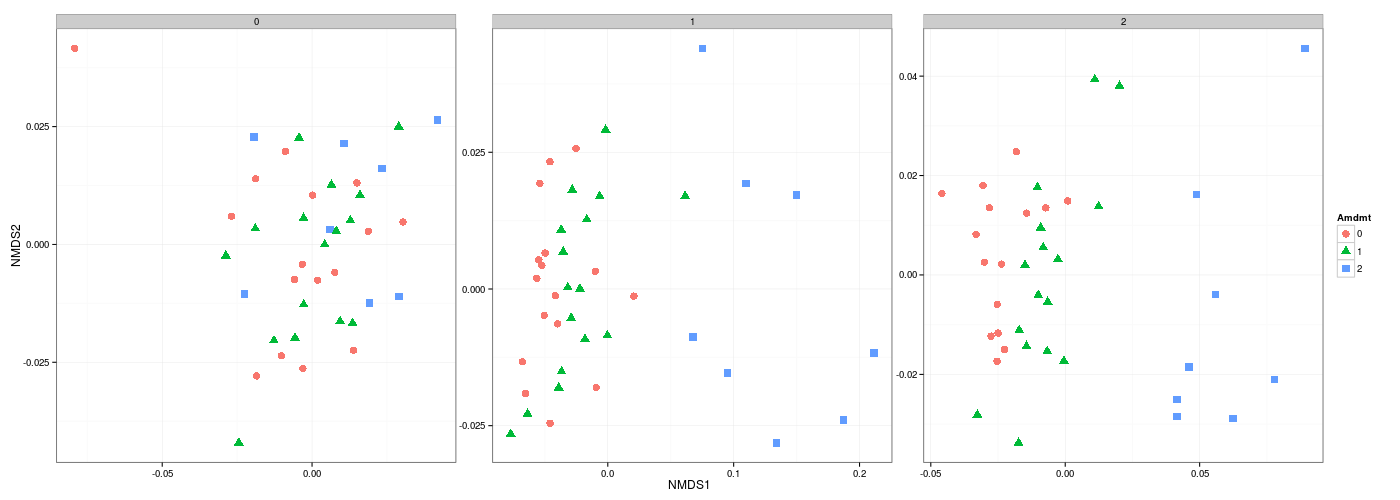

In [16]:
%%R -h 500 -w 1400
# Sets the window size above - has to happen on the first row.

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
# It is colored by Amendment (Amdmt)
p = ggplot(df.NMDS.unif, aes(x = NMDS1, y = NMDS2, color = Amdmt, shape = Amdmt))

# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days
# The axis scales are all optimized individually
# There is also a facet_grid function where you could do two variables A~B
p = p + facet_wrap(~Day, scales = "free")

# Determines the size of the symbols
p = p + geom_point(size = 3.5)

# Determines the color theme of the plot overall
p = p + theme_bw()

# Displays the plot object
p

In [25]:
%%R
otu.scores = df.NMDS.unif[df.NMDS.unif$Day == 0,c(2,3)]
    head(otu.scores)

        NMDS1        NMDS2
1 -0.01587137 -0.020886923
2  0.01361303 -0.026430210
3 -0.02378027 -0.028508346
4 -0.02031350  0.005761351
5 -0.07412382  0.051729216
6 -0.02932013  0.008639490


In [16]:
%%R
md = sample_data(physeq_snorm)
otu.scores = df.NMDS.unif[df.NMDS.unif$Day == 0,c(2,3)]
ps <- prune_samples((md$Day == 0), physeq_snorm)
w <- wascores(otu.scores, t(otu_table(ps)), expand = TRUE)

In [18]:
%%R
head(w)

                NMDS1        NMDS2
OTU.3919 -0.008513874  0.016158936
OTU.3038 -0.021911089 -0.038321561
OTU.2120 -0.008382859 -0.028683930
OTU.679  -0.025681198 -0.049711632
OTU.6355          NaN          NaN
OTU.299  -0.017873753 -0.002517041


In [33]:
%%R

md = sample_data(physeq_snorm)

otu.scores = df.NMDS.unif[df.NMDS.unif$Day == 0,c(2,3)]
psw <- prune_samples((md$Day == 0), physeq_snorm)
w <- wascores(otu.scores, t(otu_table(psw)), expand = TRUE)

In [34]:
%%R

otu.scores = df.NMDS.unif[df.NMDS.unif$Day == 1,c(2,3)]
psx <- prune_samples((md$Day == 1), physeq_snorm)
x <- wascores(otu.scores, t(otu_table(psx)), expand = TRUE)


In [36]:
%%R
otu.scores = df.NMDS.unif[df.NMDS.unif$Day == 2,c(2,3)]
psy <- prune_samples((md$Day == 2), physeq_snorm)
y <- wascores(otu.scores, t(otu_table(psy)), expand = TRUE)


In [43]:
%%R
head(y)

               NMDS1         NMDS2
OTU.3919  0.01123604 -0.0690318234
OTU.3038 -0.04228689 -0.0303744568
OTU.2120 -0.03953716 -0.0311768004
OTU.679  -0.04760339 -0.0415680737
OTU.6355         NaN           NaN
OTU.299  -0.02515321 -0.0003782424


In [ ]:
otu.ord = merge(w,x)
head(otu.ord)

In [ ]:
head(otu.ord)

In [ ]:
%%R

otu.scores = data.frame(otu.ord2)

# We also pull out the taxonomy from the physeq object
supp = tax_table(physeq_snorm)
otu.scores.wtax = data.frame(otu.scores, supp)


head(otu.scores.wtax)

In [30]:
%%R
?merge

R Help on ‘merge’merge                   package:base                   R Documentation

_M_e_r_g_e _T_w_o _D_a_t_a _F_r_a_m_e_s

_D_e_s_c_r_i_p_t_i_o_n:

     Merge two data frames by common columns or row names, or do other
     versions of database _join_ operations.

_U_s_a_g_e:

     merge(x, y, ...)
     
     ## Default S3 method:
     merge(x, y, ...)
     
     ## S3 method for class 'data.frame'
     merge(x, y, by = intersect(names(x), names(y)),
           by.x = by, by.y = by, all = FALSE, all.x = all, all.y = all,
           sort = TRUE, suffixes = c(".x",".y"),
           incomparables = NULL, ...)
     
_A_r_g_u_m_e_n_t_s:

    x, y: data frames, or objects to be coerced to one.

by, by.x, by.y: specifications of the columns used for merging.  See
          ‘Details’.

     all: logical; ‘all = L’ is shorthand for ‘all.x = L’ and ‘all.y =
          L’, where ‘L’ is either ‘TRUE’ or ‘FALSE’.

   all.x: logical; if ‘TRUE’, then e

# Running the ordination analysis separately for each treatment

In [79]:
%%R
# Set up computer to do parallel computing
registerDoParallel(cores=10)

# This is me running an ordination for a bunch of different sets (here, days), all at once
# I create a list of the variables I want to run the ordination by
amdmts = list(Soil=0, PyOM=1, Stover=2)

# Pull out the sample data from the physeq object
md = sample_data(physeq_snorm)

# Create a function that prunes samples where the Day is equal to the value from her list created above, for the physeq.
ord = function(x) {
    ps = prune_samples((md$Amdmt == x), physeq_snorm)
# Then, on this pruned set of data for just one day, perform a weighted unifrac ordination
    NMDS = ordinate(ps,
                method = "NMDS",
                distance = "unifrac",
                weighted = TRUE,
                fast = TRUE,
                parallel = TRUE)
# Then do the plot_ordination command to get just the data frame, and report that, for the first 3 axes
    p.nmds = plot_ordination(ps, NMDS, axes = c(1,2), justDF = TRUE)
    return(p.nmds)
}

# With the function  created above, we then stick together (vertically), the results from the dataframe,
# using the days string as the input that gets run through the ord function each time.
# Now, you could make plots on each day separately, by using the facet_wrap parameter in ggplot,
# And the ordinations for each day would have been calculated independently, rather than across the whole experiment
df.NMDS.unif = ldply(amdmts, ord)

Run 0 stress 0.1548899 
Run 1 stress 0.1548953 
... procrustes: rmse 0.00285019  max resid 0.01415497 
Run 2 stress 0.1548872 
... New best solution
... procrustes: rmse 0.001637051  max resid 0.007589826 
*** Solution reached

Run 0 stress 0.1543652 
Run 1 stress 0.1522064 
... New best solution
... procrustes: rmse 0.02172726  max resid 0.1241979 
Run 2 stress 0.1641005 
Run 3 stress 0.1877567 
Run 4 stress 0.4003285 
Run 5 stress 0.1640956 
Run 6 stress 0.1543618 
Run 7 stress 0.164096 
Run 8 stress 0.1783709 
Run 9 stress 0.1642714 
Run 10 stress 0.1543661 
Run 11 stress 0.1543628 
Run 12 stress 0.1655102 
Run 13 stress 0.1655056 
Run 14 stress 0.1836973 
Run 15 stress 0.1543665 
Run 16 stress 0.1537535 
Run 17 stress 0.1764452 
Run 18 stress 0.1986369 
Run 19 stress 0.1522065 
... procrustes: rmse 1.829508e-05  max resid 7.103214e-05 
*** Solution reached

Run 0 stress 0.0486323 
Run 1 stress 0.05067052 
Run 2 stress 0.05403669 
Run 3 stress 0.05154026 
Run 4 stress 0.05406341 
Ru

In [67]:
%%R
head(df.NMDS.unif)

   .id         NMDS1        NMDS2 Plants DayAmdmt Amdmt ID Day
1 Soil -0.0007283182 -0.037796920      0       00     0  A   0
2 Soil  0.0345169842 -0.033508304      1       00     0  C   0
3 Soil -0.0302727429  0.018265274      0       20     0  A   2
4 Soil -0.0145705465  0.015467993      1       10     0  C   1
5 Soil -0.0531875616  0.005279298      1       10     0  C   1
6 Soil  0.0070850429 -0.008789192      1       10     0  C   1


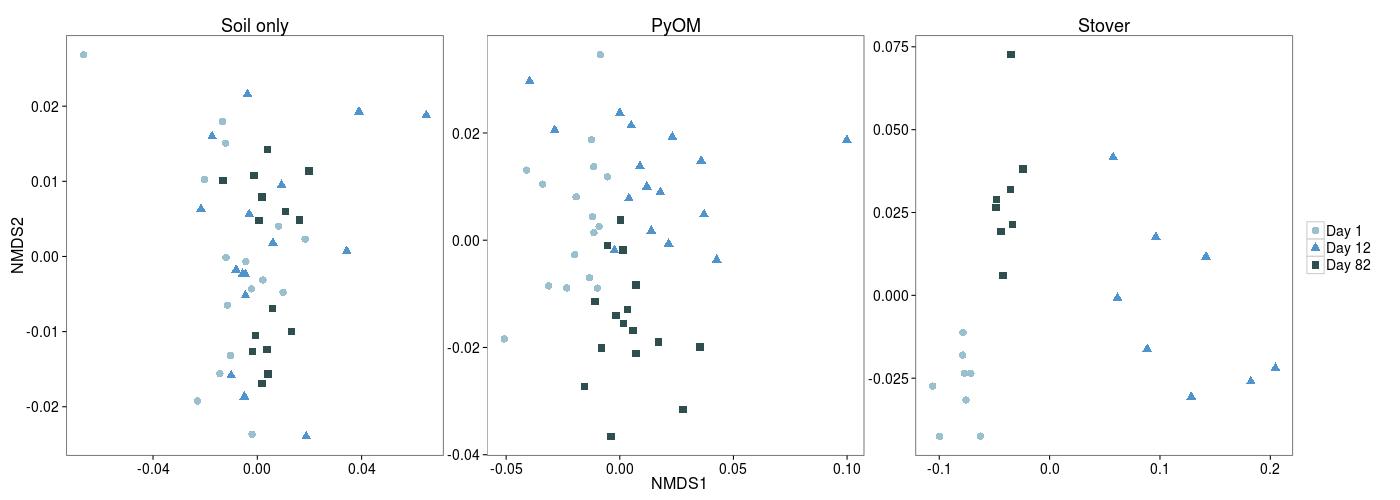

In [80]:
%%R -h 500 -w 1400
# Sets the window size above - has to happen on the first row.

d<-df.NMDS.unif

d$AmdmtName = factor(ifelse(d$Amdmt==0,"Soil only", ifelse(d$Amdmt==1,"PyOM", "Stover")))
d$AmdmtName <- factor(d$AmdmtName, levels = c("Soil only", "PyOM", "Stover"))
# Sets the amendment names and makes sure they present in order

d$DayName = ifelse(d$Day==0, "Day 1", (ifelse(d$Day==1,"Day 12","Day 82")))

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
# It is colored by Amendment (Amdmt)
p = ggplot(d, aes(x = NMDS1, y = NMDS2, color = DayName, shape = DayName))


# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days
# The axis scales are all optimized individually
# There is also a facet_grid function where you could do two variables A~B
p = p + facet_wrap(~AmdmtName, scales = "free")

# Determines the size of the symbols
p = p + geom_point(size = 3.5)

# Determines the color theme of the plot overall
p = p + theme_bw() + theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank())

p = p + scale_color_manual(values = c("lightblue3", "steelblue3", "darkslategrey"))
# sets the colour values to be black or red


p = p + theme(strip.text.x = element_text(size = 18),
              strip.text.y = element_text(size = 18),
              axis.text.x = element_text(size = 14),
              axis.title.x = element_text(size = 16),
              axis.text.y = element_text(size=14),
              axis.title.y = element_text(size = 16),
              legend.title = element_blank(),
              legend.text = element_text(size = 14),
              strip.background = element_blank())



# Displays the plot object
p

In [81]:
%%R
ggsave(filename = "NMDSbyAmdmt.pdf", plot = p, width=18, height = 6)

#Just making figures for the CSS talk...

In [58]:
%%R
# Similar approach to above - we take the object we created where we plotted the OTUs on the ordination
otu.scores = data.frame(y)

# We also pull out the taxonomy from the physeq object
supp = tax_table(physeq_snorm)

# Again, making sure they match up, now we join the two together so we have the OTU ordinations with the taxonomic info
if( setequal(row.names(otu.scores), row.names(supp)) ){
    otu.scores.wtax.day2 = data.frame(otu.scores, supp)
} else {
    print("Indices not the same.")
    print(setdiff(row.names(w.df), row.names(supp)))
}

head(otu.scores.wtax.day2)

               NMDS1         NMDS2  Kingdom         Phylum               Class
OTU.3919  0.01123604 -0.0690318234 Bacteria Actinobacteria       Rubrobacteria
OTU.3038 -0.04228689 -0.0303744568 Bacteria Proteobacteria Deltaproteobacteria
OTU.2120 -0.03953716 -0.0311768004 Bacteria Proteobacteria Deltaproteobacteria
OTU.679  -0.04760339 -0.0415680737 Bacteria Proteobacteria Deltaproteobacteria
OTU.6355         NaN           NaN Bacteria  Acidobacteria              iii1-8
OTU.299  -0.02515321 -0.0003782424 Bacteria  Acidobacteria              iii1-8
                      Order              Family Genus Species Rank1
OTU.3919    Rubrobacterales    Rubrobacteraceae  <NA>    <NA>  <NA>
OTU.3038 [Entotheonellales] [Entotheonellaceae]  <NA>    <NA>  <NA>
OTU.2120 [Entotheonellales] [Entotheonellaceae]  <NA>    <NA>  <NA>
OTU.679  [Entotheonellales] [Entotheonellaceae]  <NA>    <NA>  <NA>
OTU.6355              32-20                <NA>  <NA>    <NA>  <NA>
OTU.299               32-20            

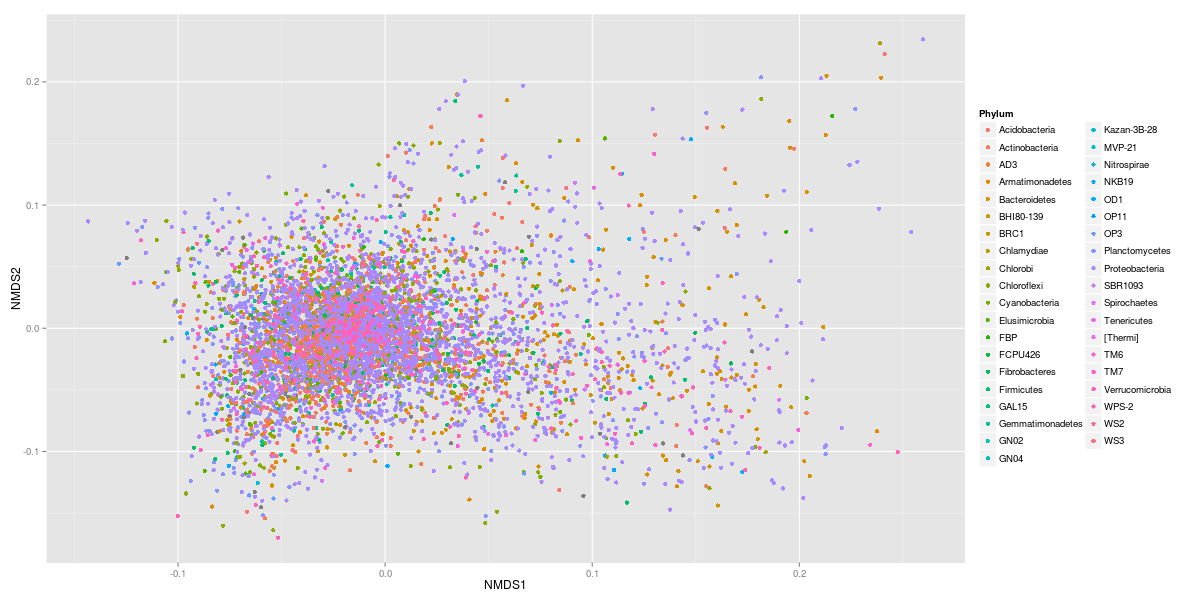

In [103]:
%%R -w 1200 -h 600
# Setting plot dimensions above - note this has to happen on the first line.
# Figuring out how many different colours we're going to need for all our unique categories we're going to plot
colourCount = length(unique(otu.scores.wtax.day2$Phylum))

# Creates plot object from the OTU ordination with taxa, plotting the two axes, but colouring by Phylum
p = ggplot(otu.scores.wtax.day2, aes(x = NMDS1, y = NMDS2, color = Phylum))

# Used to create scatterplots - can specify many more things here
p = p + geom_point()

# Tells it to display the legend with two columns, so it doesn't run off the chart
p = p + guides(color = guide_legend(ncol = 2))

p

# Okay, I think a main objective is to ask, how did biochar affect the samples?
# Because we see its effects by day 2, that is where I will focus for the talk.
# I want to see ... which taxa correspond to the biochar plot?
# ... how does the taxa breakdown compare in biochar vs. no biochar plots?

In [66]:
%%R
# Sets up a modified dataframe by "melting" the physeq object into readable information.
mdf = psmelt(physeq_snorm)
head(mdf)

            OTU Sample  Abundance Plants DayAmdmt Amdmt ID Day  Kingdom
102237   OTU.18   S147 0.12353756      0       12     2  F   1 Bacteria
102301   OTU.18   S141 0.11247601      0       12     2  F   1 Bacteria
102224   OTU.18   S148 0.10962822      0       12     2  F   1 Bacteria
376742    OTU.4   S143 0.08268212      0       12     2  F   1 Bacteria
665320 OTU.6446   S145 0.07816556      0       12     2  F   1 Bacteria
911632    OTU.9   S147 0.07316590      0       12     2  F   1 Bacteria
               Phylum               Class              Order
102237 Proteobacteria Gammaproteobacteria  Enterobacteriales
102301 Proteobacteria Gammaproteobacteria  Enterobacteriales
102224 Proteobacteria Gammaproteobacteria  Enterobacteriales
376742 Proteobacteria  Betaproteobacteria    Burkholderiales
665320 Proteobacteria  Betaproteobacteria    Burkholderiales
911632  Bacteroidetes    Sphingobacteriia Sphingobacteriales
                    Family            Genus    Species Rank1
102237  

In [76]:
%%R
# Uses the plyr library to summarize the melted physeq object created above, by Sample and Phylum,
# and creating a new column, called S, which is the sum of the abundance column.
# Thus, this sum is telling us, for each sample, for each phylum, what fraction of the total each phylum makes up.
# There is a lot more that could be done here, but this has the makings of a stacked bar chart, etc.
d = ddply(mdf, .(Day, Amdmt, Sample, Phylum), summarize, S = sum(Abundance))
head(d)

  Day Amdmt Sample          Phylum            S
1   0     0   S001   Acidobacteria 2.063437e-01
2   0     0   S001  Actinobacteria 1.139791e-01
3   0     0   S001             AD3 1.337100e-03
4   0     0   S001 Armatimonadetes 7.069192e-03
5   0     0   S001   Bacteroidetes 6.439011e-02
6   0     0   S001       BHI80-139 2.325392e-05


In [77]:
%%R
d

     Day Amdmt Sample           Phylum            S
1      0     0   S001    Acidobacteria 2.063437e-01
2      0     0   S001   Actinobacteria 1.139791e-01
3      0     0   S001              AD3 1.337100e-03
4      0     0   S001  Armatimonadetes 7.069192e-03
5      0     0   S001    Bacteroidetes 6.439011e-02
6      0     0   S001        BHI80-139 2.325392e-05
7      0     0   S001             BRC1 4.883323e-04
8      0     0   S001       Chlamydiae 1.162696e-05
9      0     0   S001         Chlorobi 1.976583e-04
10     0     0   S001      Chloroflexi 3.739231e-02
11     0     0   S001    Cyanobacteria 1.930075e-03
12     0     0   S001    Elusimicrobia 5.732092e-03
13     0     0   S001              FBP 3.023010e-04
14     0     0   S001          FCPU426 6.162289e-04
15     0     0   S001    Fibrobacteres 1.488251e-03
16     0     0   S001       Firmicutes 1.360354e-02
17     0     0   S001            GAL15 3.488088e-05
18     0     0   S001 Gemmatimonadetes 2.490495e-02
19     0    

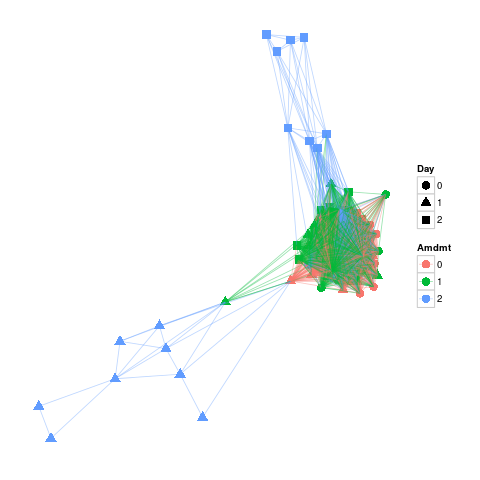

In [80]:
%%R
ntwk = make_network(physeq_snorm, max.dist = 0.5)
p<-plot_network(ntwk, physeq_snorm, color = "Amdmt", shape = "Day", line_weight = 0.4, label = NULL)
p

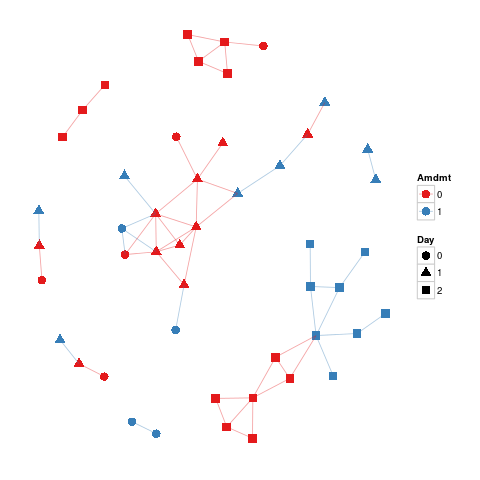

In [102]:
%%R
ntwk = make_network(physeq_snorm, max.dist = 0.3)
p <-plot_network(ntwk, physeq_snorm, color = "Amdmt", shape = "Day", line_weight = 0.4, label = NULL)

p <- p + scale_colour_brewer(palette="Set1")

p

In [97]:
%%R
# prune to just the top 100 most abundant OTUs across all samples (crude).
Tax100 = prune_taxa(names(sort(taxa_sums(physeq_snrom), TRUE))[1:100], physeq_snorm)
ntwk = make_network(Tax100, "taxa", "jaccard", 0.3)
plot_network(ntwk, Tax100, "taxa", color = "Phylum", line_weight = 0.4, label = NULL)

Error in prune_taxa(names(sort(taxa_sums(physeq_snrom), TRUE))[1:100],  : 
  error in evaluating the argument 'taxa' in selecting a method for function 'prune_taxa': Error in otu_table(x) : 
  error in evaluating the argument 'object' in selecting a method for function 'otu_table': Error: object 'physeq_snrom' not found


In [105]:
%%R
?prune_taxa

R Help on ‘prune_taxa’prune_taxa              package:phyloseq               R Documentation

_P_r_u_n_e _u_n_w_a_n_t_e_d _O_T_U_s / _t_a_x_a _f_r_o_m _a _p_h_y_l_o_g_e_n_e_t_i_c _o_b_j_e_c_t.

_D_e_s_c_r_i_p_t_i_o_n:

     An S4 Generic method for removing (pruning) unwanted OTUs/taxa
     from phylogenetic objects, including phylo-class trees, as well as
     native phyloseq package objects. This is particularly useful for
     pruning a phyloseq object that has more than one component that
     describes OTUs. Credit: the ‘phylo’-class version is adapted from
     prune.sample.

_U_s_a_g_e:

       prune_taxa(taxa, x)
     
_A_r_g_u_m_e_n_t_s:

    taxa: (Required). A character vector of the taxa in object x that
          you want to keep - OR alternatively - a logical vector where
          the kept taxa are TRUE, and length is equal to the number of
          taxa in object x. If ‘taxa’ is a named logical, the t

# I want to see what the acidobacteria are doing on each day.

In [132]:
%%R
Acido.Family = ddply(mdf[mdf$Phylum=="Acidobacteria",],.(Day, Amdmt, Sample, Phylum, Class, Order, Family), summarize, S = sum(Abundance))
head(Acido.Family)

  Day Amdmt Sample        Phylum           Class   Order Family           S
1   0     0   S001 Acidobacteria Acidobacteria-5    <NA>   <NA> 0.006766891
2   0     0   S001 Acidobacteria Acidobacteria-6  BPC015   <NA> 0.000000000
3   0     0   S001 Acidobacteria Acidobacteria-6   CCU21   <NA> 0.004162452
4   0     0   S001 Acidobacteria Acidobacteria-6 iii1-15 mb2424 0.003336938
5   0     0   S001 Acidobacteria Acidobacteria-6 iii1-15   RB40 0.011987396
6   0     0   S001 Acidobacteria Acidobacteria-6 iii1-15   <NA> 0.080632972


In [133]:
%%R
nrow(Acido.Family)

[1] 4523


In [135]:
%%R
# Okay, it looks like I did manage to get only the Acidobacteria phyla. I will print this and look at it now.
Acido.Family

      Day Amdmt Sample        Phylum                Class            Order
1       0     0   S001 Acidobacteria      Acidobacteria-5             <NA>
2       0     0   S001 Acidobacteria      Acidobacteria-6           BPC015
3       0     0   S001 Acidobacteria      Acidobacteria-6            CCU21
4       0     0   S001 Acidobacteria      Acidobacteria-6          iii1-15
5       0     0   S001 Acidobacteria      Acidobacteria-6          iii1-15
6       0     0   S001 Acidobacteria      Acidobacteria-6          iii1-15
7       0     0   S001 Acidobacteria       Acidobacteriia Acidobacteriales
8       0     0   S001 Acidobacteria       Acidobacteriia Acidobacteriales
9       0     0   S001 Acidobacteria       Acidobacteriia Acidobacteriales
10      0     0   S001 Acidobacteria               AT-s54             <NA>
11      0     0   S001 Acidobacteria               BPC102           MVS-40
12      0     0   S001 Acidobacteria               BPC102             <NA>
13      0     0   S001 Ac